# Exploratory Data Analyses

An exporatory data analysis (EDA) provides a summarization of a dataset to get an idea of the how the data is structured and distributed before any modeling is done. Most often included are basic statistics,  like five-number summaries (i.e. min, Q1, median, Q3, max), means, and ANOVAs, and data visualizations. 

For the dataset, we will be using the _World Happiness Report 2021_, which is the current report at the time of writing. The dataset can also be found [here](https://gitlab.com/mtopacio/notebooks/-/blob/master/datasets/World_Health_Report_2021.csv) under my repo at _Gitlab_. The condition should not be considered standard, as the data set comes to us already cleaned with no missing values. 

First, we'll by importing this dataset along with all the other some other dependencies. Visualizations will be made with [Plotly](https://plotly.com/) and its wrapper _plotly-express_. Data will be handled through dataframes via _Pandas_. `google.colab` has some modules to load data into its notebooks; however, I'll be using `pandas` to read in data from an online source.

`statsmodels` will be used to perform an ANOVA to get a first glimpse at correlations between variables.


In [23]:
# dependencies            
from sklearn import preprocessing
from statsmodels.formula.api import ols
import statsmodels.api as sm
import plotly, plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import itertools
import pandas

In [24]:
# data sets are stored in repo
data = pandas.read_csv('https://gitlab.com/mtopacio/notebooks/-/raw/master/datasets/World_Health_Report_2021.csv')
data.head()

Country name  ... Dystopia + residual
0      Finland  ...               3.253
1      Denmark  ...               2.868
2  Switzerland  ...               2.839
3      Iceland  ...               2.967
4  Netherlands  ...               2.798

[5 rows x 20 columns]

We can see that most of the columns are made of quantitative variables, with the only categorical one being the region of the country. 

We can also edit and rename some of the columns to make it easier to work with. The values for the _Explained by:_ columns are the percentage of the ladder score attributed to that column. These along with some other columnns will be dropped for not only for brevity, but also because the information they capture is based on the other values.

In [25]:
# dropping columns
columns_to_drop = [col for col in list(data.columns) if col.split(' ')[0] == 'Explained']
other_columns = ['Standard error of ladder score', 'upperwhisker', 'lowerwhisker', 'Dystopia + residual','Ladder score in Dystopia']
columns_to_drop.extend(other_columns)

data = data.drop(columns_to_drop, axis=1)

# renaming columns
data = data.rename(columns={'Country name':'country', 'Regional indicator':'region', 'Ladder score':'happiness', 
                            'Logged GDP per capita':'economy','Social support':'welfare', 'Healthy life expectancy':'health',
                            'Freedom to make life choices':'freedom', 'Generosity':'generosity','Perceptions of corruption':'corruption'})

data

country              region  ...  generosity  corruption
0        Finland      Western Europe  ...      -0.098       0.186
1        Denmark      Western Europe  ...       0.030       0.179
2    Switzerland      Western Europe  ...       0.025       0.292
3        Iceland      Western Europe  ...       0.160       0.673
4    Netherlands      Western Europe  ...       0.175       0.338
..           ...                 ...  ...         ...         ...
144      Lesotho  Sub-Saharan Africa  ...      -0.131       0.915
145     Botswana  Sub-Saharan Africa  ...      -0.246       0.801
146       Rwanda  Sub-Saharan Africa  ...       0.061       0.167
147     Zimbabwe  Sub-Saharan Africa  ...      -0.047       0.821
148  Afghanistan          South Asia  ...      -0.102       0.924

[149 rows x 9 columns]

In [26]:
# if your data set is to large, you may choose to sample your data set instead
data.sample(10)

country                              region  ...  generosity  corruption
0          Finland                      Western Europe  ...      -0.098       0.186
6           Sweden                      Western Europe  ...       0.086       0.237
100     Bangladesh                          South Asia  ...      -0.041       0.682
111          Gabon                  Sub-Saharan Africa  ...      -0.200       0.840
40          Panama         Latin America and Caribbean  ...      -0.166       0.856
119        Liberia                  Sub-Saharan Africa  ...       0.050       0.850
18   United States               North America and ANZ  ...       0.098       0.698
74         Belarus  Commonwealth of Independent States  ...      -0.180       0.627
43          Poland          Central and Eastern Europe  ...      -0.165       0.735
141       Tanzania                  Sub-Saharan Africa  ...       0.183       0.577

[10 rows x 9 columns]

In [27]:
# maybe filter it by region
filters = data['region'] == 'Western Europe'
data[filters].sample(10)

country          region  happiness  ...  freedom  generosity  corruption
0      Finland  Western Europe      7.842  ...    0.949      -0.098       0.186
1      Denmark  Western Europe      7.620  ...    0.946       0.030       0.179
9      Austria  Western Europe      7.268  ...    0.908       0.042       0.481
67      Greece  Western Europe      5.723  ...    0.582      -0.288       0.823
26       Spain  Western Europe      6.491  ...    0.761      -0.081       0.745
7   Luxembourg  Western Europe      7.324  ...    0.907      -0.034       0.386
57    Portugal  Western Europe      5.929  ...    0.892      -0.244       0.887
22       Malta  Western Europe      6.602  ...    0.927       0.133       0.653
14     Ireland  Western Europe      7.085  ...    0.879       0.077       0.363
12     Germany  Western Europe      7.155  ...    0.875       0.011       0.460

[10 rows x 9 columns]

---

## Structure and Basic Stats

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     149 non-null    object 
 1   region      149 non-null    object 
 2   happiness   149 non-null    float64
 3   economy     149 non-null    float64
 4   welfare     149 non-null    float64
 5   health      149 non-null    float64
 6   freedom     149 non-null    float64
 7   generosity  149 non-null    float64
 8   corruption  149 non-null    float64
dtypes: float64(7), object(2)
memory usage: 10.6+ KB


In [29]:
data.shape

(149, 9)

In [30]:
data.columns

Index(['country', 'region', 'happiness', 'economy', 'welfare', 'health',
       'freedom', 'generosity', 'corruption'],
      dtype='object')

In [31]:
data.describe()

happiness     economy     welfare  ...     freedom  generosity  corruption
count  149.000000  149.000000  149.000000  ...  149.000000  149.000000  149.000000
mean     5.532839    9.432208    0.814745  ...    0.791597   -0.015134    0.727450
std      1.073924    1.158601    0.114889  ...    0.113332    0.150657    0.179226
min      2.523000    6.635000    0.463000  ...    0.382000   -0.288000    0.082000
25%      4.852000    8.541000    0.750000  ...    0.718000   -0.126000    0.667000
50%      5.534000    9.569000    0.832000  ...    0.804000   -0.036000    0.781000
75%      6.255000   10.421000    0.905000  ...    0.877000    0.079000    0.845000
max      7.842000   11.647000    0.983000  ...    0.970000    0.542000    0.939000

[8 rows x 7 columns]

In [32]:
# stats by a specific column (i.e. regions)
region_data = data.groupby(['region'])
region_data['happiness'].describe()

count      mean  ...      75%    max
region                                               ...                
Central and Eastern Europe           17.0  5.984765  ...  6.25500  6.965
Commonwealth of Independent States   12.0  5.467000  ...  5.74950  6.179
East Asia                             6.0  5.810333  ...  5.91625  6.584
Latin America and Caribbean          20.0  5.908050  ...  6.31100  7.069
Middle East and North Africa         17.0  5.219765  ...  6.10600  7.157
North America and ANZ                 4.0  7.128500  ...  7.20650  7.277
South Asia                            7.0  4.441857  ...  5.11150  5.269
Southeast Asia                        9.0  5.407556  ...  5.88000  6.377
Sub-Saharan Africa                   36.0  4.494472  ...  4.99925  6.049
Western Europe                       21.0  6.914905  ...  7.39200  7.842

[10 rows x 8 columns]

We've imported the data into _Google Colab_ where we can see it has the shape of 149 rows x 20 columns. Now we can start looking at some stats. `info` can be helpful in determining your data types. It may be necessary to change data types when resources are limited. 

You can also see that there are no missing values within this data set.

In [33]:
# changing a quantitative variable into a categorical one
data['quartile'] = pandas.qcut(data['happiness'], q=4, labels=['Fourth','Third','Second','First'])
data

country              region  ...  corruption  quartile
0        Finland      Western Europe  ...       0.186     First
1        Denmark      Western Europe  ...       0.179     First
2    Switzerland      Western Europe  ...       0.292     First
3        Iceland      Western Europe  ...       0.673     First
4    Netherlands      Western Europe  ...       0.338     First
..           ...                 ...  ...         ...       ...
144      Lesotho  Sub-Saharan Africa  ...       0.915    Fourth
145     Botswana  Sub-Saharan Africa  ...       0.801    Fourth
146       Rwanda  Sub-Saharan Africa  ...       0.167    Fourth
147     Zimbabwe  Sub-Saharan Africa  ...       0.821    Fourth
148  Afghanistan          South Asia  ...       0.924    Fourth

[149 rows x 10 columns]

---
## Visualizations

This section focuses on visualizing how the data is oriented with each other. We can start by exploring the categorical variable `quartile` we created up above.

In [34]:
# box-and-whisker plots of the categorical value we created
px.box(data, x='quartile', y='happiness', points='all')

In [35]:
px.histogram(data, x='happiness')

In [36]:
# showing the same info, but as a probability density 
# with the actual points overlayed on top
px.histogram(data, x='happiness', histnorm='probability density', marginal='rug')

In [37]:
# combination histograms of all quantitative variables
column_names = list(data.columns)
cat_columns = ['region', 'country', 'quartile']
[column_names.remove(cat_col) for cat_col in cat_columns]

fig = make_subplots(rows=len(column_names),cols=1)

for i,col_name in enumerate(column_names):
  trace = go.Histogram(x=data[col_name], name=col_name.capitalize())
  fig.append_trace(trace,i+1,1)

fig.update_layout(height=1800)
fig.show()

Build histograms around your data. The above used the selected defaults for the axis scales and number of bins; however, it may be necessary to make adjustments if your data is completely consolidated on one side or if there is a large number of gaps between bars. The point is to illustrate the distribution effectively.

First impressions, most of these categories are skewed; however, _happiness_ and _corruption_ seem to be normally distributed.

In [38]:
# scatter_matrix produces too much information for these cell, so maybe limit the columns of interest
px.scatter_matrix(data, dimensions = ['economy','welfare','health','freedom','generosity','corruption'], color = 'quartile')

In [39]:
px.scatter(data, x='economy',
           y='health', 
           color='region', 
           size='happiness',
           labels = {'region':'Area',
                     'happiness':'Happiness Score'}, 
           title='The Effects of Freedom and Economy on Happiness')

---
## ANOVAs

First two parts explored the data. Any generalized leads can be further addressed by exploring the variances between the data points to try and explore any correlations. We can use the `statsmodels` package to analyze variances between groups and the outcome variable, _happiness_. You'll also notice the syntax used to describe your model is similar to _R_.

The model created is an _Ordinary Least Squares_, which is a form if linear regression.

Based on the scatter plots above, the spread of economy, health, and welfare seems relatively tight when compared to happiness.

In [40]:
# ordinary least square
model = ols('happiness ~ economy + health + welfare', data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              happiness   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     109.0
Date:                Wed, 28 Apr 2021   Prob (F-statistic):           5.51e-37
Time:                        03:59:34   Log-Likelihood:                -133.61
No. Observations:                 149   AIC:                             275.2
Df Residuals:                     145   BIC:                             287.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4058      0.478     -5.032      0.0

The `statsmodels` package also has its own buil-in plotting functions via matlab it uses to expand on relatinoships.

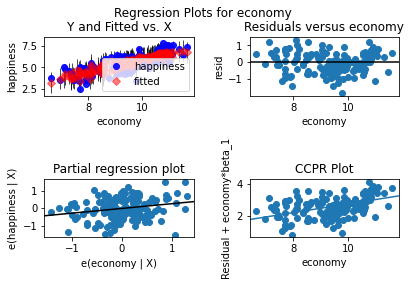

In [41]:
# influence plots via statsmodels
fig = sm.graphics.plot_regress_exog(model, 'economy')
fig.tight_layout(pad=2.0)

In [42]:
# ANOVA Linear Model
sm.stats.anova_lm(model, typ=2)

sum_sq     df          F    PR(>F)
economy    3.045167    1.0   8.421612  0.004287
health     3.476440    1.0   9.614327  0.002320
welfare    6.584329    1.0  18.209400  0.000036
Residual  52.430487  145.0        NaN       NaN